This notebook runs inference on random images from the test set and plots the results.
Ground-truth points are shown in blue. True positive predictions are shown in green, while false positive predictions are shown in red.

In [85]:
from detectron2.config import get_cfg
from detectron2.engine import default_setup

# Set up cfg
cfg_path = "configs/PDwRN.yaml"
custom_cfg = [
    "MODEL.WEIGHTS", "output/model_final.pth", 
    "MODEL.RETINANET.SCORE_THRESH_TEST", "0.8"
]
cfg = get_cfg()
cfg.merge_from_file(cfg_path)
cfg.merge_from_list(custom_cfg)

print("Configurations setup complete.")
# print(cfg)

Configurations setup complete.


In [86]:
from detectron2.modeling import build_model
from models import PDwRN
from detectron2.engine import DefaultPredictor

# Build the model
# model = build_model(cfg)
predictor = DefaultPredictor(cfg)
print("Model loading complete.")
# print(predictor.model)

Model loading complete.


In [98]:
from utils import setup_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import build_detection_test_loader, build_detection_train_loader

# Load the dataset
data_path = "/home/myeghiaz/Project/PDwRN/data/"
debug_on = False
if "LINZ_train" and "LINZ_test" in DatasetCatalog:
    print("Datasets have already been registered. Continuing without registration.")
else:
    print("Registering the datasets.")
    setup_dataset(data_path=data_path, debug_on=debug_on)

# Initialize the dataloader
# LINZ_dataset = DatasetCatalog.get("LINZ_test")
# LINZ_metadata = MetadataCatalog.get("LINZ_test")
LINZ_dataset = DatasetCatalog.get("LINZ_train")
LINZ_metadata = MetadataCatalog.get("LINZ_train")

print("Dataset setup complete.")

Datasets have already been registered. Continuing without registration.


100%|█████████████████████████████████████| 64426/64426 [00:07<00:00, 9013.34it/s]

Dataset setup complete.


In [99]:
LINZ_dataset = [LINZ_detection for LINZ_detection in LINZ_dataset if len(LINZ_detection['annotations']) > 0]
LINZ_dataset = [LINZ_detection for LINZ_detection in LINZ_dataset if LINZ_detection['file_name'] == '/home/myeghiaz/Project/PDRN/data/train/images/0003_0002_0003398.jpg']
print(f"Dataset cleaning complete. Length of the new dataset: {len(LINZ_dataset)}.")

Dataset cleaning complete. Length of the new dataset: 1.


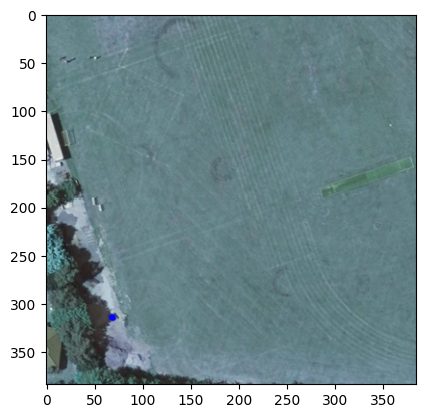

There are 1 ground-truth points in this image.
Number of predictions: 0.


In [100]:
import random
import cv2
import torch
from matplotlib import pyplot as plt

from detectron2.utils.visualizer import Visualizer

import pdb

# Run inference
for d in random.sample(LINZ_dataset, 1):
    image = cv2.imread(d['file_name'])
    outputs = predictor(image)
    v = Visualizer(image[:, :, ::-1],
                   metadata=LINZ_metadata, 
                   scale=1.0, 
    )
    out = None

    gt_points = []
    for vehicle_coordinate in d['annotations']:
        vehicle = {
            "gt_point": torch.tensor(vehicle_coordinate['gt_point']).long().cuda(),
            "category_id": torch.tensor(0).long().cuda(),
            "status": torch.tensor(0).long().cuda()
        }
        gt_points.append(vehicle) # appends a numpy array consisting of 2 values in (x, y) format
    pred_points = {
                "points": outputs['instances'].pred_boxes.get_centers().long().cuda(),
                "status": torch.tensor([0 for _ in range(len(outputs['instances']))]).long().cuda()
            }
    # Evaluate the predictions based on the ground-truth points
    for gt_idx in range(len(gt_points)):
        gt_point = gt_points[gt_idx]
        for pred_idx in range(len(pred_points['points'])):
            pred_point = pred_points['points'][pred_idx]
                    
            # Compute the distance between the given pair of points
            # NOTE: a prediction is accepted if it's within 6 pixels from the ground-truth point
            gt_pred_dist = (gt_point['gt_point'] - pred_point).pow(2).sum().sqrt()
            if gt_pred_dist < 6:
                gt_points[gt_idx]['status'] = torch.tensor(1).long().cuda()
                pred_points['status'][pred_idx] = torch.tensor(1).long().cuda()
                break
    
    # Draw ground-truth points
    for gt_point in gt_points:
        out = v.draw_circle(gt_point['gt_point'], 'r', 3)
    
    # Draw predictions
    k = 0
    for pred_point in pred_points['points']:
        if pred_points['status'][k] == 1:
            point_colour = 'g'
        else:
            point_colour = 'b'
        out = v.draw_circle(pred_point, point_colour, 2)
        k += 1
    
    if out is not None:
        plt.imshow(out.get_image()[:, :, ::-1])
    else:
        plt.imshow(image)
    plt.show()
    print(f"There are {len(d['annotations'])} ground-truth points in this image.")
    print(f"Number of predictions: {len(outputs['instances'])}.")